# Overview

Recently, the variety of assets that can be invested has skyrocketed, mainly in terms of Crypto. However, due to the extreme volatility of cryptocurrency, many investors end up liquidating and losing all their money. Therefore, the possible prediction on cryptocurrency has a huge impact both socially and commercially. By using ARIMA and LSTM models presented in this report, both retail and institutional investors can have a more reasonable buying and selling time and maximize their profits.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf  # auto-correkation
from statsmodels.tsa.stattools import adfuller as ADF  # test of stationarity
from statsmodels.graphics.tsaplots import plot_pacf    # partial auto-correlation
# from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.metrics import mean_squared_error
from math import sqrt
import optuna

# Load and clean dataset

In [2]:
date_index = pd.read_csv("../data/BTC_daily_ARIMA.csv")["Date"]
date_index = date_index.iloc[::-1]

Our main objective is to predict the average price of Bitcoin at the given date. To predict, we use the method of time series analysis. We use the following formula to calculate the volume weighted average price.

$$\frac{\sum_{all\;transactions} price  × volume\;of\;each\;transaction}{total\;volume}$$

In [3]:
file_list_hour = ["../data/BTC_hourly_ARIMA.csv", "../data/gemini_BTCUSD_1hr.csv", "../data/gemini_ETHBTC_1hr.csv", "../data/gemini_ETHUSD_1hr.csv", 
"../data/gemini_LTCUSD_1hr.csv", "../data/gemini_ZECBTC_1hr.csv", "../data/gemini_ZECETH_1hr.csv", "../data/gemini_ZECUSD_1hr.csv"]
df = []

for i in range(len(file_list_hour)):
    df.append(pd.read_csv(file_list_hour[i]))


df_close_hour = np.array(df[0]['Close'])[::-1]
df_high_hour = np.array(df[0]['High'])[::-1]
df_low_hour = np.array(df[0]['Low'])[::-1]
df_volume_hour = np.array(df[0]['Volume'])[::-1]
vwap = []
residual = (df_close_hour.size) % 24

In [4]:
for i in range(df_close_hour.size//24):

    close_hour_sub = df_close_hour[i*24 + residual: (i+1)*24 + residual] #list of 24

    high_hour_sub = df_high_hour[i*24 + residual: (i+1)*24 + residual ] #list of 24

    low_hour_sub = df_low_hour[i*24 + residual : (i+1)*24 + residual ] #list of 24

    volume_hour_sub = df_volume_hour[i*24 + residual : (i+1)*24 + residual ] # 24hr trade volumes list of 24

    average_hour_sub = ((close_hour_sub + high_hour_sub + low_hour_sub)/3) * volume_hour_sub #list of 24
    
    if sum(volume_hour_sub) == 0:
        vwap_day = close_hour_sub[0]
    else:
        vwap_day = sum(average_hour_sub)/sum(volume_hour_sub)

    vwap.append(vwap_day)

vwap = pd.Series(vwap, index=date_index)
vwap.name = "Vwap"

In [5]:
data = vwap

# Exploratory data analysis

We plot the trend of price of Bitcoin in a line graph (from 2015-10-09 to now).

<AxesSubplot:xlabel='Date'>

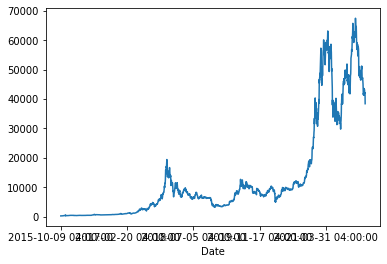

In [6]:
data.plot()

From the ACF (Autoregressive integrated moving average) Plot, we can find the data between neighbouring date has a high correlation.

C:\Users\YIZONG~1\AppData\Local\Temp/ipykernel_37168/1137652694.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(data).show()


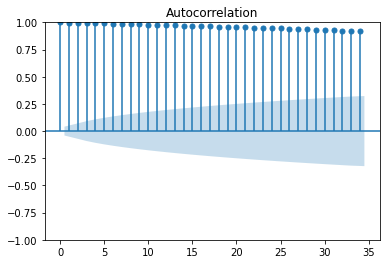

In [7]:
plot_acf(data).show()

ADF test shows that the squence of data is not stationary.

In [8]:
ADF(data)

(-1.250016245946306,
 0.6517187292684102,
 27,
 2269,
 {'1%': -3.433235285765301,
  '5%': -2.862814646891805,
  '10%': -2.5674485535435454},
 36202.65552977727)

It can be seen that non stationarity exists in the time series data. Hence, we explore further by taking the differences between each two neighbouring data point to form a new sequence.

<AxesSubplot:xlabel='Date'>

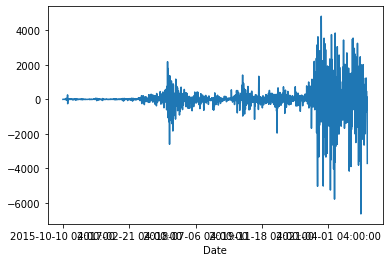

In [9]:
D_data = data.diff().dropna()
D_data.plot()

It can be seen that first order differencing sequence of the original sequence fails to  auto-correlate and the stationarity exists, so we can use ARIMA model with the degree of differencing equal to 1.

C:\Users\YIZONG~1\AppData\Local\Temp/ipykernel_37168/2538248294.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(D_data).show()


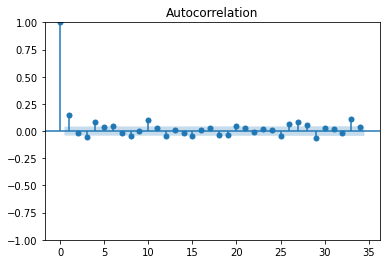

In [10]:
plot_acf(D_data).show()

In [11]:
ADF(D_data)

(-7.176881553430232,
 2.7127387504411983e-10,
 27,
 2268,
 {'1%': -3.43323655938138, '5%': -2.86281520927122, '10%': -2.567448852970086},
 36183.67693162202)

To minimize the Bayesian Information Coefficient, we choose p = 0, q = 1 as the hyperparameters of our model. The performance of this model is evaluated below.

In [17]:
training_data = data[:1838]
test_data = data[1838:]

pmax = 10
qmax = 10

# Objective function to be optimized
def objective(trial):

    p = trial.suggest_int('p', 0, pmax)

    q = trial.suggest_int('q', 0, qmax)

    model = ARIMA(training_data, order = (p,1,q)).fit()

    goal = model.bic
    
    return goal

study = optuna.create_study(direction = "minimize")

study.optimize(objective, n_trials=100, timeout = 60, show_progress_bar = True)

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

best = study.best_trial

print("Best Parameter:", study.best_params) 

[I 2022-01-22 23:57:02,756] A new study created in memory with name: no-name-766d6e76-5ae0-441d-b29b-3cf25a0b4a00
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided

[I 2022-01-22 23:57:03,075] Trial 0 finished with value: 25519.427880192754 and parameters: {'p': 1, 'q': 2}. Best is trial 0 with value: 25519.427880192754.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 2/100 [00:04<04:29,  2.75s/it, 4.77/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency 

[I 2022-01-22 23:57:07,530] Trial 1 finished with value: 25571.878995367442 and parameters: {'p': 5, 'q': 10}. Best is trial 0 with value: 25519.427880192754.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 3/100 [00:08<04:49,  2.98s/it, 8.02/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency 

[I 2022-01-22 23:57:10,781] Trial 2 finished with value: 25578.66000171942 and parameters: {'p': 9, 'q': 5}. Best is trial 0 with value: 25519.427880192754.
[I 2022-01-22 23:57:10,937] Trial 3 finished with value: 25548.734868000123 and parameters: {'p': 7, 'q': 0}. Best is trial 0 with value: 25519.427880192754.


  5%|▌         | 5/100 [00:08<02:01,  1.28s/it, 8.42/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency infor

[I 2022-01-22 23:57:11,179] Trial 4 finished with value: 25557.657256490384 and parameters: {'p': 9, 'q': 0}. Best is trial 0 with value: 25519.427880192754.


  6%|▌         | 6/100 [00:09<01:41,  1.08s/it, 9.10/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency infor

[I 2022-01-22 23:57:11,859] Trial 5 finished with value: 25522.57644242713 and parameters: {'p': 2, 'q': 2}. Best is trial 0 with value: 25519.427880192754.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 7/100 [00:15<04:19,  2.79s/it, 15.41/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency

[I 2022-01-22 23:57:18,169] Trial 6 finished with value: 25597.905086455197 and parameters: {'p': 9, 'q': 10}. Best is trial 0 with value: 25519.427880192754.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  8%|▊         | 8/100 [00:19<04:50,  3.16s/it, 19.36/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency

[I 2022-01-22 23:57:22,123] Trial 7 finished with value: 25574.72731559554 and parameters: {'p': 5, 'q': 9}. Best is trial 0 with value: 25519.427880192754.


  9%|▉         | 9/100 [00:20<03:58,  2.62s/it, 20.80/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency info

[I 2022-01-22 23:57:23,555] Trial 8 finished with value: 25557.38268931089 and parameters: {'p': 2, 'q': 7}. Best is trial 0 with value: 25519.427880192754.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 10/100 [00:24<04:37,  3.09s/it, 24.93/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequenc

[I 2022-01-22 23:57:27,684] Trial 9 finished with value: 25582.803070994658 and parameters: {'p': 6, 'q': 10}. Best is trial 0 with value: 25519.427880192754.
[I 2022-01-22 23:57:27,802] Trial 10 finished with value: 25532.957024602165 and parameters: {'p': 0, 'q': 3}. Best is trial 0 with value: 25519.427880192754.


 12%|█▏        | 12/100 [00:25<02:29,  1.70s/it, 25.66/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:28,419] Trial 11 finished with value: 25534.36324818208 and parameters: {'p': 2, 'q': 3}. Best is trial 0 with value: 25519.427880192754.


 13%|█▎        | 13/100 [00:26<01:59,  1.37s/it, 26.27/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:29,027] Trial 12 finished with value: 25522.57644242713 and parameters: {'p': 2, 'q': 2}. Best is trial 0 with value: 25519.427880192754.
[I 2022-01-22 23:57:29,113] Trial 13 finished with value: 25525.79515734924 and parameters: {'p': 0, 'q': 2}. Best is trial 0 with value: 25519.427880192754.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 15%|█▌        | 15/100 [00:28<01:48,  1.28s/it, 28.61/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequenc

[I 2022-01-22 23:57:31,373] Trial 14 finished with value: 25540.046952503613 and parameters: {'p': 3, 'q': 5}. Best is trial 0 with value: 25519.427880192754.


 16%|█▌        | 16/100 [00:29<01:31,  1.09s/it, 29.15/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:31,912] Trial 15 finished with value: 25540.00030885081 and parameters: {'p': 3, 'q': 1}. Best is trial 0 with value: 25519.427880192754.


 17%|█▋        | 17/100 [00:29<01:18,  1.06it/s, 29.67/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:32,427] Trial 16 finished with value: 25528.43500815619 and parameters: {'p': 1, 'q': 4}. Best is trial 0 with value: 25519.427880192754.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 18%|█▊        | 18/100 [00:32<02:04,  1.52s/it, 32.73/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequenc

[I 2022-01-22 23:57:35,494] Trial 17 finished with value: 25552.780989592826 and parameters: {'p': 4, 'q': 6}. Best is trial 0 with value: 25519.427880192754.


 19%|█▉        | 19/100 [00:33<01:38,  1.21s/it, 33.15/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:35,906] Trial 18 finished with value: 25519.427880192754 and parameters: {'p': 1, 'q': 2}. Best is trial 0 with value: 25519.427880192754.
[I 2022-01-22 23:57:36,078] Trial 19 finished with value: 25536.73722956663 and parameters: {'p': 0, 'q': 4}. Best is trial 0 with value: 25519.427880192754.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 21%|██        | 21/100 [00:34<01:08,  1.15it/s, 34.07/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:36,834] Trial 20 finished with value: 25549.950421392332 and parameters: {'p': 7, 'q': 1}. Best is trial 0 with value: 25519.427880192754.


 22%|██▏       | 22/100 [00:34<00:57,  1.36it/s, 34.50/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:37,255] Trial 21 finished with value: 25519.427880192754 and parameters: {'p': 1, 'q': 2}. Best is trial 0 with value: 25519.427880192754.
[I 2022-01-22 23:57:37,393] Trial 22 finished with value: 25525.804092941587 and parameters: {'p': 1, 'q': 1}. Best is trial 0 with value: 25519.427880192754.


 24%|██▍       | 24/100 [00:35<00:46,  1.63it/s, 35.38/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:38,137] Trial 23 finished with value: 25540.445531750913 and parameters: {'p': 1, 'q': 3}. Best is trial 0 with value: 25519.427880192754.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 25%|██▌       | 25/100 [00:36<01:06,  1.14it/s, 36.88/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequenc

[I 2022-01-22 23:57:39,644] Trial 24 finished with value: 25542.818964865844 and parameters: {'p': 3, 'q': 4}. Best is trial 0 with value: 25519.427880192754.
[I 2022-01-22 23:57:39,737] Trial 25 finished with value: 25539.13509380309 and parameters: {'p': 4, 'q': 0}. Best is trial 0 with value: 25519.427880192754.


 27%|██▋       | 27/100 [00:37<00:42,  1.71it/s, 37.35/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:40,114] Trial 26 finished with value: 25519.427880192754 and parameters: {'p': 1, 'q': 2}. Best is trial 0 with value: 25519.427880192754.


 28%|██▊       | 28/100 [00:37<00:37,  1.91it/s, 37.70/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:40,455] Trial 27 finished with value: 25547.814167348028 and parameters: {'p': 0, 'q': 7}. Best is trial 0 with value: 25519.427880192754.


 29%|██▉       | 29/100 [00:38<00:42,  1.67it/s, 38.51/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:41,270] Trial 28 finished with value: 25531.239478442636 and parameters: {'p': 4, 'q': 1}. Best is trial 0 with value: 25519.427880192754.


 30%|███       | 30/100 [00:39<00:45,  1.54it/s, 39.29/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:42,047] Trial 29 finished with value: 25540.445531750913 and parameters: {'p': 1, 'q': 3}. Best is trial 0 with value: 25519.427880192754.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 31%|███       | 31/100 [00:41<01:13,  1.07s/it, 41.45/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequenc

[I 2022-01-22 23:57:44,208] Trial 30 finished with value: 25540.046952503613 and parameters: {'p': 3, 'q': 5}. Best is trial 0 with value: 25519.427880192754.


 32%|███▏      | 32/100 [00:41<00:57,  1.18it/s, 41.74/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:44,501] Trial 31 finished with value: 25519.427880192754 and parameters: {'p': 1, 'q': 2}. Best is trial 0 with value: 25519.427880192754.


 33%|███▎      | 33/100 [00:42<00:50,  1.31it/s, 42.29/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:45,047] Trial 32 finished with value: 25522.57644242713 and parameters: {'p': 2, 'q': 2}. Best is trial 0 with value: 25519.427880192754.
[I 2022-01-22 23:57:45,110] Trial 33 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:45,147] Trial 34 finished with value: 25601.247477885954 and parameters: {'p': 0, 'q': 0}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:45,208] Trial 35 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.


 37%|███▋      | 37/100 [00:43<00:27,  2.30it/s, 43.25/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:46,008] Trial 36 finished with value: 25562.4809271309 and parameters: {'p': 10, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:46,045] Trial 37 finished with value: 25601.247477885954 and parameters: {'p': 0, 'q': 0}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:46,104] Trial 38 finished with value: 25525.8168600128 and parameters: {'p': 2, 'q': 0}. Best is trial 33 with value: 25518.475081956756.


 40%|████      | 40/100 [00:44<00:21,  2.77it/s, 44.07/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:46,827] Trial 39 finished with value: 25556.337863267603 and parameters: {'p': 8, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:46,923] Trial 40 finished with value: 25532.957024602165 and parameters: {'p': 0, 'q': 3}. Best is trial 33 with value: 25518.475081956756.


 42%|████▏     | 42/100 [00:44<00:16,  3.58it/s, 44.25/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:47,010] Trial 41 finished with value: 25525.804092941587 and parameters: {'p': 1, 'q': 1}. Best is trial 33 with value: 25518.475081956756.


 43%|████▎     | 43/100 [00:44<00:16,  3.54it/s, 44.55/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:47,307] Trial 42 finished with value: 25519.427880192754 and parameters: {'p': 1, 'q': 2}. Best is trial 33 with value: 25518.475081956756.


 44%|████▍     | 44/100 [00:45<00:17,  3.15it/s, 45.00/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:47,761] Trial 43 finished with value: 25534.36324818208 and parameters: {'p': 2, 'q': 3}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:47,836] Trial 44 finished with value: 25525.79515734924 and parameters: {'p': 0, 'q': 2}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:47,887] Trial 45 finished with value: 25521.54715421974 and parameters: {'p': 1, 'q': 0}. Best is trial 33 with value: 25518.475081956756.


 47%|████▋     | 47/100 [00:46<00:19,  2.69it/s, 46.06/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:48,820] Trial 46 finished with value: 25535.15809182637 and parameters: {'p': 2, 'q': 4}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:48,880] Trial 47 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:48,947] Trial 48 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.


 50%|█████     | 50/100 [00:46<00:12,  3.89it/s, 46.25/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:49,008] Trial 49 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.


 51%|█████     | 51/100 [00:46<00:11,  4.24it/s, 46.58/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:49,339] Trial 50 finished with value: 25562.38912501822 and parameters: {'p': 0, 'q': 9}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:49,400] Trial 51 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:49,459] Trial 52 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:49,503] Trial 53 finished with value: 25601.247477885954 and parameters: {'p': 0, 'q': 0}. Best is trial 33 with value: 25518.475081956756.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 55%|█████▌    | 55/100 [00:46<00:06,  7.31it/s, 46.80/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:49,563] Trial 54 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:49,622] Trial 55 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:49,656] Trial 56 finished with value: 25601.247477885954 and parameters: {'p': 0, 'q': 0}. Best is trial 33 with value: 25518.475081956756.


 58%|█████▊    | 58/100 [00:47<00:07,  5.27it/s, 47.60/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:50,360] Trial 57 finished with value: 25543.321626418314 and parameters: {'p': 6, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:50,453] Trial 58 finished with value: 25525.804092941587 and parameters: {'p': 1, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:50,513] Trial 59 finished with value: 25525.8168600128 and parameters: {'p': 2, 'q': 0}. Best is trial 33 with value: 25518.475081956756.


 61%|██████    | 61/100 [00:47<00:06,  6.33it/s, 47.83/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:50,595] Trial 60 finished with value: 25525.79515734924 and parameters: {'p': 0, 'q': 2}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:50,652] Trial 61 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:50,731] Trial 62 finished with value: 25525.79515734924 and parameters: {'p': 0, 'q': 2}. Best is trial 33 with value: 25518.475081956756.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 64%|██████▍   | 64/100 [00:48<00:07,  5.00it/s, 48.

[I 2022-01-22 23:57:51,383] Trial 63 finished with value: 25542.709210606306 and parameters: {'p': 1, 'q': 6}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:51,445] Trial 64 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:51,506] Trial 65 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:51,560] Trial 66 finished with value: 25521.54715421974 and parameters: {'p': 1, 'q': 0}. Best is trial 33 with value: 25518.475081956756.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 68%|██████▊   | 68/100 [00:49<00:06,  4.98it/s, 49.

[I 2022-01-22 23:57:52,105] Trial 67 finished with value: 25540.445531750913 and parameters: {'p': 1, 'q': 3}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:52,189] Trial 68 finished with value: 25525.79515734924 and parameters: {'p': 0, 'q': 2}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:52,240] Trial 69 finished with value: 25521.54715421974 and parameters: {'p': 1, 'q': 0}. Best is trial 33 with value: 25518.475081956756.


 71%|███████   | 71/100 [00:49<00:04,  6.20it/s, 49.92/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:52,682] Trial 70 finished with value: 25537.422850018596 and parameters: {'p': 5, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:52,741] Trial 71 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:52,801] Trial 72 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.


 74%|███████▍  | 74/100 [00:50<00:04,  5.37it/s, 50.35/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:53,106] Trial 73 finished with value: 25519.427880192754 and parameters: {'p': 1, 'q': 2}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:53,186] Trial 74 finished with value: 25525.79515734924 and parameters: {'p': 0, 'q': 2}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:53,247] Trial 75 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.


 77%|███████▋  | 77/100 [00:50<00:03,  6.59it/s, 50.52/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:53,284] Trial 76 finished with value: 25601.247477885954 and parameters: {'p': 0, 'q': 0}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:53,372] Trial 77 finished with value: 25525.804092941587 and parameters: {'p': 1, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:53,408] Trial 78 finished with value: 25601.247477885954 and parameters: {'p': 0, 'q': 0}. Best is trial 33 with value: 25518.475081956756.


 80%|████████  | 80/100 [00:50<00:02,  7.37it/s, 50.93/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:53,694] Trial 79 finished with value: 25519.427880192754 and parameters: {'p': 1, 'q': 2}. Best is trial 33 with value: 25518.475081956756.


 81%|████████  | 81/100 [00:51<00:02,  7.37it/s, 51.20/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:53,959] Trial 80 finished with value: 25533.24100043217 and parameters: {'p': 2, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:54,021] Trial 81 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:54,081] Trial 82 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:54,116] Trial 83 finished with value: 25601.247477885954 and parameters: {'p': 0, 'q': 0}. Best is trial 33 with value: 25518.475081956756.


 85%|████████▌ | 85/100 [00:51<00:01,  9.06it/s, 51.44/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:54,195] Trial 84 finished with value: 25525.79515734924 and parameters: {'p': 0, 'q': 2}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:54,287] Trial 85 finished with value: 25525.804092941587 and parameters: {'p': 1, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:54,345] Trial 86 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.


 88%|████████▊ | 88/100 [00:51<00:01,  9.94it/s, 51.63/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:54,392] Trial 87 finished with value: 25521.54715421974 and parameters: {'p': 1, 'q': 0}. Best is trial 33 with value: 25518.475081956756.


 89%|████████▉ | 89/100 [00:51<00:01,  8.62it/s, 51.90/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:54,656] Trial 88 finished with value: 25554.831821239637 and parameters: {'p': 0, 'q': 8}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:54,752] Trial 89 finished with value: 25532.957024602165 and parameters: {'p': 0, 'q': 3}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:54,838] Trial 90 finished with value: 25525.804092941587 and parameters: {'p': 1, 'q': 1}. Best is trial 33 with value: 25518.475081956756.


C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 92%|█████████▏| 92/100 [00:52<00:00,  9.18it/s, 52.

[I 2022-01-22 23:57:54,896] Trial 91 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:54,953] Trial 92 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.


 94%|█████████▍| 94/100 [00:52<00:00, 10.65it/s, 52.92/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:55,683] Trial 93 finished with value: 25563.860894129426 and parameters: {'p': 8, 'q': 2}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:55,743] Trial 94 finished with value: 25518.475081956756 and parameters: {'p': 0, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:55,781] Trial 95 finished with value: 25601.247477885954 and parameters: {'p': 0, 'q': 0}. Best is trial 33 with value: 25518.475081956756.


 97%|█████████▋| 97/100 [00:53<00:00,  5.60it/s, 53.32/60 seconds]C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Yi Zong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency inf

[I 2022-01-22 23:57:56,084] Trial 96 finished with value: 25519.427880192754 and parameters: {'p': 1, 'q': 2}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:56,176] Trial 97 finished with value: 25525.804092941587 and parameters: {'p': 1, 'q': 1}. Best is trial 33 with value: 25518.475081956756.
[I 2022-01-22 23:57:56,212] Trial 98 finished with value: 25601.247477885954 and parameters: {'p': 0, 'q': 0}. Best is trial 33 with value: 25518.475081956756.


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, 53.93/60 seconds]

[I 2022-01-22 23:57:56,690] Trial 99 finished with value: 25551.635974829107 and parameters: {'p': 6, 'q': 2}. Best is trial 33 with value: 25518.475081956756.
Study statistics: 
  Number of finished trials:  100
Best Parameter: {'p': 0, 'q': 1}


In [22]:
p = 0
q = 1
history = [x for x in training_data]
predictions = list()
# walk-forward validation
for t in range(len(test_data)):
	model = ARIMA(history, order=(p,1,q))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test_data[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes


predicted=11717.915448, expected=11894.199274
predicted=11933.363943, expected=12674.673193
predicted=12839.982168, expected=12980.042261
predicted=13011.264746, expected=12898.328963
predicted=12873.050203, expected=13061.361569
predicted=13103.477608, expected=13104.015399
predicted=13104.135643, expected=13037.227208
predicted=13022.260196, expected=13567.603382
predicted=13689.459417, expected=13303.771778
predicted=13218.456044, expected=13421.124694
predicted=13465.810206, expected=13490.900497
predicted=13496.441086, expected=13791.525317
predicted=13856.707051, expected=13780.058021
predicted=13763.153100, expected=13560.611020
predicted=13515.868448, expected=13741.562036
predicted=13791.346978, expected=13993.978089
predicted=14038.746841, expected=15000.812670
predicted=15214.497113, expected=15565.865616
predicted=15644.282215, expected=15067.235556
predicted=14937.967481, expected=15279.749907
predicted=15355.551477, expected=15317.371320
predicted=15308.899463, expected=1

The plot shows that the model fits the prediction well.

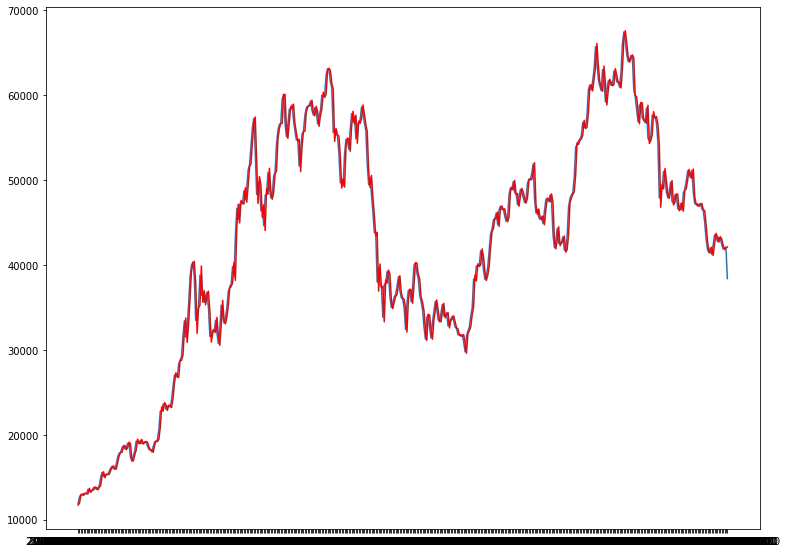

In [23]:
fig = plt.figure(figsize = (12.8, 9.6))
plt.plot(test_data)
plt.plot(predictions, color='red')
plt.show()